# 1. Setup

In [1]:
from mobilkit.umni import *

# 2. SafeGraph

## 2.1. POI categories
Each SafeGraph POI category was manually classified by trip purpose and essentiality.

In [2]:
cats = pd.read_excel('../data/pois/sg_categories.xlsx', header=0, usecols='A:D').disp()

90 rows x 4 cols; Memory: 0.0 MiB


,sg_category,count,purpose,kind
,<object>,<int64>,<object>,<object>
0,Restaurants and Other Eating Places,12457,Social/Recreational,Food/Drink


In [3]:
c = cats.rename(columns=dict(sg_category='sg_cat', count='n_pois'))
c.purpose = pd.Categorical(c.purpose.str.title(), [
    'Shopping', 'Social/Recreational', 'Services'])
c.kind = c.kind.str.title().astype(CAT)
c = (c.groupby(['purpose', 'kind'])
     .agg({'n_pois': sum, 'sg_cat': list}).dropna()
     .rename_axis(('Purpose', 'Category')))
c.n_pois = [f'{x:,}' for x in c.n_pois]
c.sg_cat = c.sg_cat.apply(lambda x: '; '.join(sorted(x)))
c = c.rename(columns=dict(n_pois='No. of places', sg_cat='SafeGraph categories'))
U.disp_table(c, [dict(selector='td, th', props=[
    ('border', '1px solid grey !important'), ('text-align', 'left')]),
                 dict(selector='td:last-child', props=[
    ('font-size', '12px'), ('width', '500px')])])

/tmp/ipykernel_31786/3627667702.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  c = (c.groupby(['purpose', 'kind'])
/tmp/ipykernel_31786/3627667702.py:6: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  .agg({'n_pois': sum, 'sg_cat': list}).dropna()


In [5]:
df = gpd.read_parquet('../data/pois/pois.parquet').disp()

69,385 rows x 11 cols; Memory: 23.2 MiB; CRS: {"$schema": "https://proj.org/schemas/v0.5/projjson.schema.json", "type": "GeographicCRS", "name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}, {"name": "Geodetic longitude", "abbreviation": "Lon", "direction": "east", "unit": "degree"}]}, "scope": "Horizontal c

,id,name,category,fclass,geometry,source,lon,lat,area_sqft,visits,visitors
,<object>,<object>,<object>,<object>,<geometry>,<object>,<float32>,<float32>,<float64>,<float64>,<float64>
0,358649475,Black School,Education,school,POINT (-88.003086 37.853656),OSM,NaN,NaN,NaN,NaN,NaN


## 2.2. Process POIs

In [5]:
SP.start()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/02 09:03:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/02 09:03:29 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [6]:
def get_sg_pois(rgn: str, categories=cats, year=2020,
                poi_path=SAFEGRAPH / 'pois/us/2020-11-06.parquet',
                vis_path=SAFEGRAPH / 'patterns/monthly/2020-01-01',
                overwrite=False):
    """Prepare SafeGraph POI data for the given region.

    Args:
        rgn (str): Name of target study region;
            must correspond to a zones filename.
        categories (Pdf): SafeGraph categories mapped to NHTS 
            purpose and specific POI kinds for the paper.
        poi_path (Path): Path of SafeGraph POI data (depends on date).
        vis_path (Path): Path of SafeGraph visit patterns data.
    """
    outpath = Path(f'../data/pois/{rgn.lower()}_2020.parquet')
    if outpath.exists() and not overwrite:
        return gpd.read_parquet(outpath).set_crs(CRS_DEG)
    zones = (gpd.read_parquet(f'../data/zones/{rgn.lower()}_{year}.parquet')
             .query('scale == "COUNTY"').to_crs(CRS_DEG).dissolve())
    poi = pd.read_parquet(poi_path, columns=[
        'placekey', 'top_category', 'lon', 'lat', 'area_sqft'])
    poi['area'] = poi.pop('area_sqft') * 0.09290304 # sq.ft. to sq.m.
    poi = (mk.geo.pdf2gdf(poi, 'lon', 'lat', CRS_DEG)
           .sjoin(zones[['geometry']], predicate='within')
           .rename(columns=D(placekey='id', top_category='sg_category'))
           .merge(categories, on='sg_category')
           [['id', 'purpose', 'kind', 'sg_category', 'area', 'geometry']])
    areas = pd.concat([df.set_index('id')['area'].interpolate('linear')
                       for _, df in poi.groupby('sg_category')]).reset_index()
    poi = poi.drop(columns='area').merge(areas, on='id').fillna(0)
    poi_sdf = SP.pdf2sdf(poi[['id']])
    vis = SP.read_parquet(vis_path).select(*[F.col(k).alias(v) for k, v in D(
        placekey='id', raw_visits='visits', raw_visitors='visitors'
    ).items()]).join(poi_sdf, on='id').toPandas()
    poi = poi.merge(vis, on='id')
    poi.to_parquet(U.mkfile(outpath))
    return poi

poiIN = get_sg_pois('IN', overwrite=0).disp() # t=0:17
poiMSA = get_sg_pois('MSA', overwrite=0).disp(0) # t=2:09

80,742 rows x 8 cols; Memory: 24.9 MiB; CRS: EPSG:4326


,id,purpose,kind,sg_category,geometry,area,visits,visitors
,<object>,<object>,<object>,<object>,<geometry>,<float64>,<int32>,<int32>
0,zzw-223@5py-97y-gzf,Shopping,Specialty,Other Miscellaneous Store Retailers,POINT (-86.530296 39.139484),424.752699,244,117


2,077,030 rows x 8 cols; Memory: 641.8 MiB; CRS: EPSG:4326


,id,purpose,kind,sg_category,geometry,area,visits,visitors
,<object>,<object>,<object>,<object>,<geometry>,<float64>,<int32>,<int32>


## 2.3. Prepare visit patterns

In [7]:
# def get_sg_visits(save=True, overwrite=False,
#                   poi_path=Path('../data/pois/sg_pois.parquet'),
#                   vis_path=SAFEGRAPH / 'patterns/monthly/2020-01-01',
#                   od_outpath=Path('../data/pois/sg_od.parquet')):
#     if od_outpath.exists() and not overwrite:
#         return SP.read_parquet(od_outpath)
#     poi = SP.read_parquet(poi_path).withColumnRenamed('placekey', 'id')
#     vis = SP.read_parquet(vis_path).select(*[
#         F.col(k).alias(v) for k, v in [
#             ('placekey', 'id'), ('raw_visits', 'visits'),
#             ('raw_visitors', 'visitors'), ('visitor_home_cbgs', 'home_bgs')]])
#     poi = poi.join(vis.drop('home_bgs'), on='id')
#     od = vis.select(F.col('id').alias('poi_id'),
#                     F.explode('home_bgs').alias('home_bg', 'visitors'))
#     poi = poi.toPandas()
#     areas = pd.concat([df.set_index('id').area_sqft.interpolate('linear')
#                        for _, df in poi.groupby('category')]).reset_index()
#     poi = poi.drop(columns='area_sqft').merge(areas, on='id').fillna(0)
#     poi = Gdf(poi, geometry=gpd.GeoSeries.from_wkb(poi.geometry), crs=CRS_DEG)
#     od = od.toPandas().astype({'poi_id': CAT, 'home_bg': CAT})
#     if save:
#         poi.to_parquet(poi_path)
#         od.to_parquet(U.mkfile(od_outpath))
#     return od
    
# sg_od = get_sg_visits(overwrite=0).disp() # t=3:44

# 3. Visualize

## 3.1. POI attribute distributions

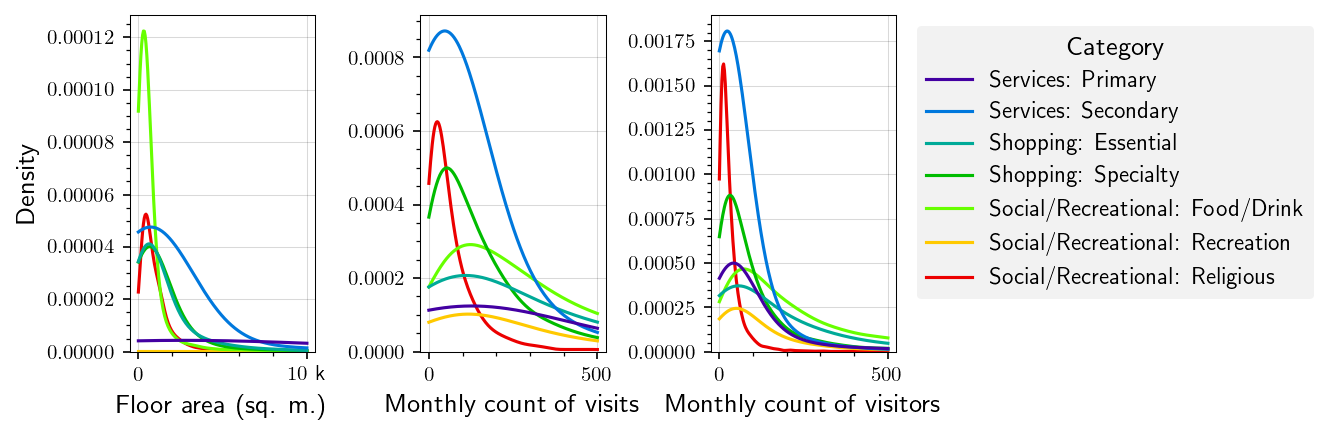

In [8]:
def plot_poi_distr_kde(pois, cols=[
    ('area', 'Floor area (sq. m.)', 1e4),
    ('visits', 'Monthly count of visits', 5e2),
    ('visitors', 'Monthly count of visitors', 5e2)
], size=(9, 3), cmap='nipy_spectral'):
    _, axes = plt.subplots(1, len(cols), figsize=size)
    for i, (var, label, vmax) in enumerate(cols):
        ax = U.plot(axes[i], xlab=label, xeng=var == 'area')
        df = (pois.assign(Category=lambda df: df.purpose + ': ' + df.kind)
             .sort_values('Category'))
        ax = sns.kdeplot(df, ax=ax, x=var, hue='Category',
                         clip=(0, vmax), palette=cmap)
        leg = ax.get_legend()
        leg.set_bbox_to_anchor((1.05, 1)) if i == len(cols) - 1 else leg.remove()
        if i != 0: ax.set_ylabel('')
        ax.ticklabel_format(axis='y', style='sci')
    plt.tight_layout()

plot_poi_distr_kde(poiIN) # t=0:04

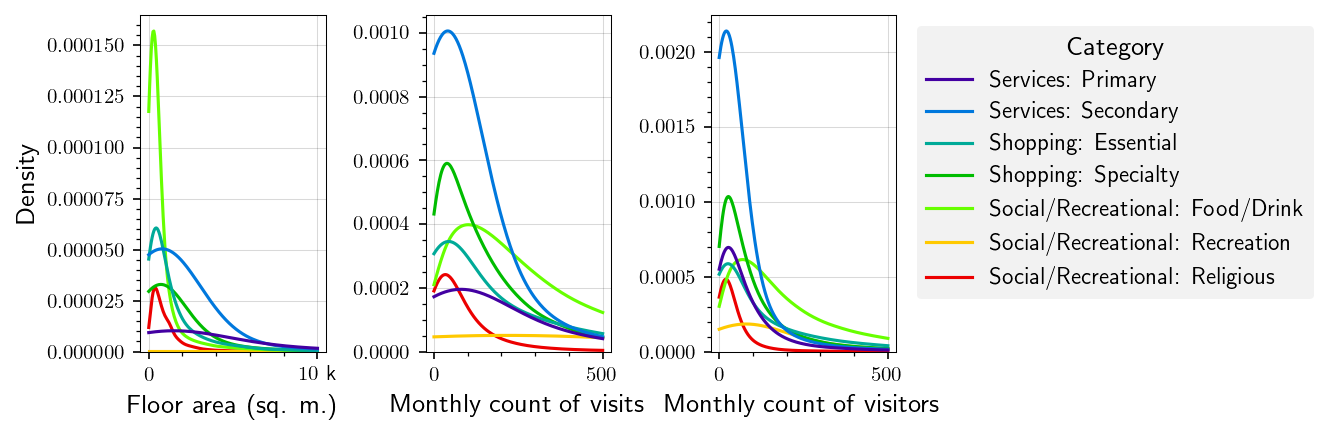

In [9]:
plot_poi_distr_kde(poiMSA) # t=0:44

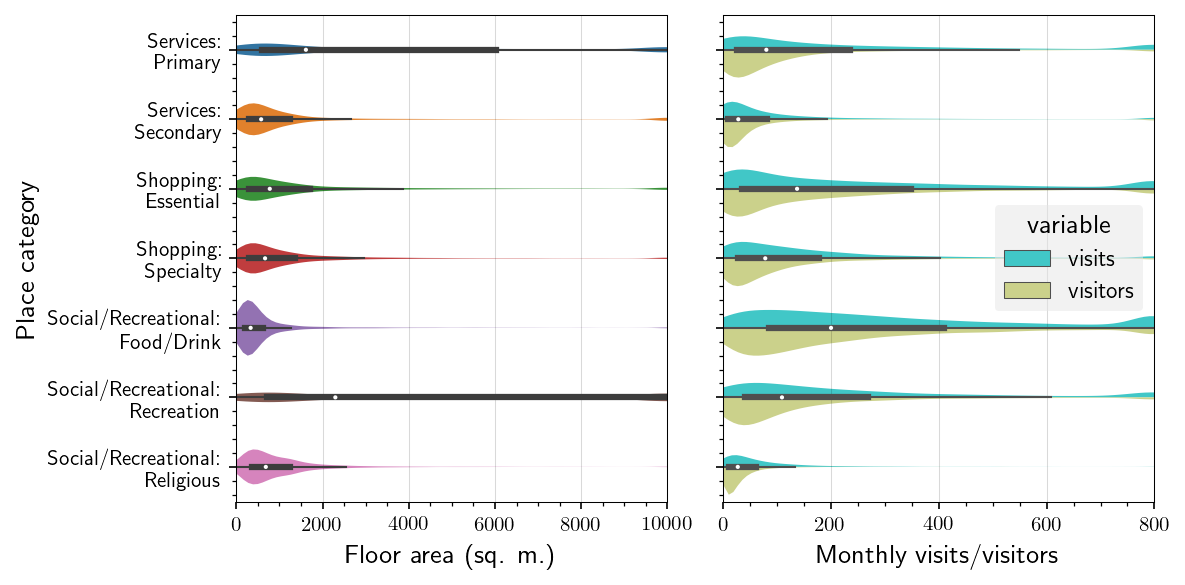

In [10]:
def plot_poi_distr_violin(pois, vmax=(1e4, 800), size=(8, 4), bw=0.2):
    df = pois.assign(kind=pois.purpose + ':\n' + pois.kind)
    df = df.sort_values('kind')
    df['area'] = df['area'].clip(0, vmax[0])
    df.visits = df.visits.clip(0, vmax[1])
    df.visitors = df.visitors.clip(0, vmax[1])
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=size)
    sns.violinplot(df, ax=ax1, y='kind', x='area', linewidth=1, bw_adjust=bw)
    U.plot(ax1, xlab='Floor area (sq. m.)', ylab='Place category',
           xlim=(0, vmax[0]))
    sns.violinplot(df.melt('kind', ['visits', 'visitors']),
                   ax=ax2, x='value', y='kind', hue='variable',
                   linewidth=1, palette='rainbow', split=True, bw_adjust=bw)
    U.plot(ax2, xlab='Monthly visits/visitors', ylab='', xlim=(0, vmax[1]))
    ax2.set_yticklabels([])
    for ax in [ax1, ax2]:
        for x in ax.collections: x.set_edgecolor('none')
    plt.tight_layout()

plot_poi_distr_violin(poiIN) # t=0:03

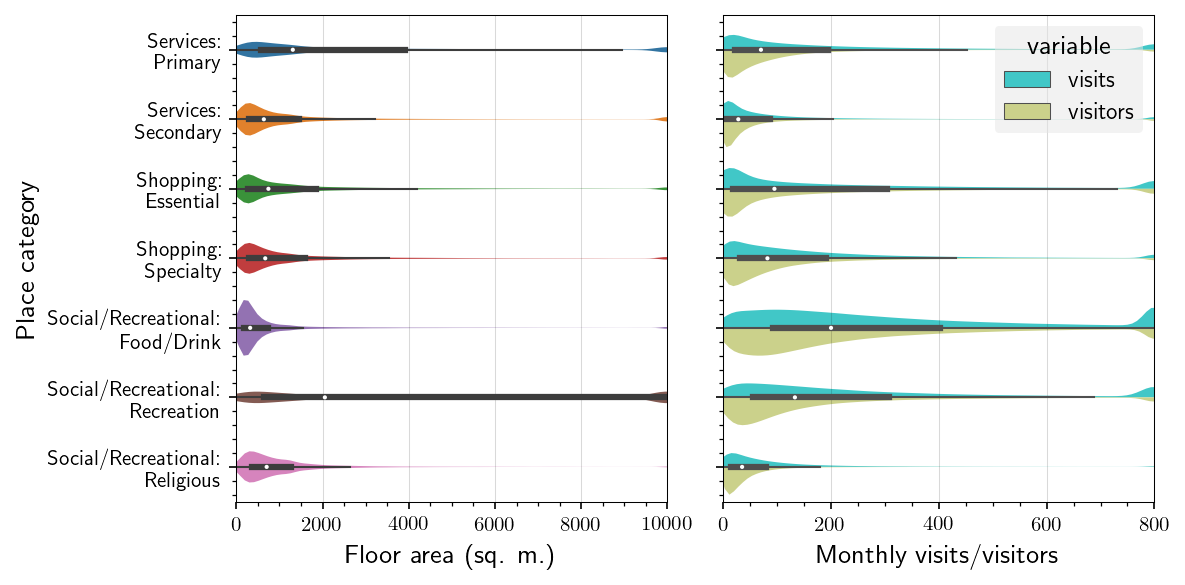

In [11]:
plot_poi_distr_violin(poiMSA) # t=0:21